# Simple two layer autoencoder on STFT data

Taken from https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py



In [1]:
from __future__ import division, print_function, absolute_import
%pylab inline
import wget
from scipy.io import wavfile
import librosa
import tensorflow as tf
import numpy as np
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
fname = 'Stockhausen_Kontakte.wav'

if not os.path.exists(fname):
    url = 'https://www.dropbox.com/s/f717af2vhiagcbp/'+fname+'?dl=1'
    filename = wget.download(url)

In [54]:
from scipy.signal import resample
# Read wav file to floating values
fs_orig,x = wavfile.read(fname)
fs = 22050
x = resample(x, x.size*fs/fs_orig)

t1 = 10*fs
t2 = 80*fs
x = x[t1:t2]
x = np.float64(x)/2**15
# Peak Normalization

x/=abs(x).max()

# Extract overlapping frames and create a spectrogram in each one

L = x.size

frame_size = 2**15
step_size = int(frame_size/2)

# Number of frames
n_frames = int( (L-frame_size)/step_size+1 )

block_size = 2**11
hop = int(block_size/4)
NFFT = block_size

level_threshold = 1e-5

n_blocks = int( (frame_size-block_size)/hop)+1+ int(block_size/hop)

S = []

# # STFT
# for i in range(n_frames):
#     frame = x[i*step_size:i*step_size+frame_size]
#     S_ = librosa.stft(frame,n_fft=NFFT,hop_length=hop,win_length=block_size )/2/NFFT
#     if abs(S_).mean()>level_threshold:
#         S_ = 20*log10(abs(S_)).clip(-60,0)
#         S_ = (S_ - S_.min()) /(S_.max() - S_.min())
#         S.append( S_ )

# CQT
S_ = []
n_bins = 84
for i in range(n_frames):
    frame = x[i*step_size:i*step_size+frame_size]
    rms = np.sqrt((frame**2).mean())
    if rms>level_threshold:
        S_.append( librosa.cqt(frame,sr=fs,hop_length=hop,fmin=40.0,n_bins=n_bins,real=False) )

max_ = max([abs(s).max() for s in S_])
S = []
for s in S_:
    s = 20*log10(abs(s/max_)).clip(-60,0)
    s = (s - s.min()) /(s.max() - s.min())
    S.append(s)
        

print(n_frames)
print("Dimensions: frames, freq bins, time bins")
S = np.array(S)
batch_length, freq_bins,time_bins = S.shape
print(batch_length, freq_bins,time_bins)


/usr/local/lib/python3.4/dist-packages/scipy/signal/signaltools.py:1889: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = zeros(newshape, 'D')


93
Dimensions: frames, freq bins, time bins
93 84 65


In [56]:
class Data():
    
    def __init__(self,data):
        import random
        
        self.data = data
        self.batch_ix = 0
        self.length = self.data.shape[0]
        self.ixs = list(range(self.length))
        random.shuffle(self.ixs)
        
    def next_batch(self,batch_size):
        self.batch_ix+= batch_size
        self.batch_ix = (self.batch_ix+batch_size) % self.length
        return self.data[self.ixs[self.batch_ix:self.batch_ix+batch_size]]
    
data = Data( S.reshape((S.shape[0],S.shape[1]*S.shape[2])) )
n_stfts = data.length


In [61]:
# Parameters
learning_rate = 0.01
training_epochs = 150
batch_size = 64

display_step = 5

# Network Parameters
dimensions= [256,128,64]

n_input = data.data.shape[1]

In [62]:
# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

weights = {}
biases = {}
layer_input = n_input

for layer_i, layer_output in enumerate(dimensions[:]):
    weights['encoder_h'+str(layer_i)] = tf.Variable(tf.random_normal([layer_input, layer_output]))
    biases['encoder_b'+str(layer_i)] = tf.Variable(tf.random_normal([layer_output]))
    layer_input = layer_output

for layer_i, layer_output in enumerate(dimensions[:-1][::-1]+[n_input]):
    weights['decoder_h'+str(layer_i)] = tf.Variable(tf.random_normal([layer_input, layer_output]))
    biases['decoder_b'+str(layer_i)] = tf.Variable(tf.random_normal([layer_output]))
    layer_input = layer_output
    
shape = tf.nn.sigmoid

# Building the encoder
layers = {}
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_input = x
    
    for layer_i, layer_output in enumerate(dimensions[:]):
        layers[layer_i] = shape(tf.add(tf.matmul(layer_input, weights['encoder_h'+str(layer_i)]), 
                                               biases['encoder_b'+str(layer_i)]))
        layer_input = layers[layer_i]

    return layer_input


# Building the decoder
def decoder(x):

    layer_input = x
    for layer_i, layer_output in enumerate(dimensions[:]):
        layers[layer_i] = shape(tf.add(tf.matmul(layer_input, weights['decoder_h'+str(layer_i)]), 
                                               biases['decoder_b'+str(layer_i)]))
        layer_input = layers[layer_i]

    return layer_input

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()

In [63]:
# Launch the graph
config = tf.ConfigProto( device_count = {'GPU': 0} )
sess = tf.Session(config=config)
sess.run(init)
total_batch = int(data.length/batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs = data.next_batch(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        opt,cost_value = sess.run([optimizer, cost], feed_dict={X: batch_xs})

    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),"cost=", "{:.9f}".format(cost_value))

print("Optimization Finished!")

Epoch: 0001 cost= 0.255572587
Epoch: 0006 cost= 0.194949687
Epoch: 0011 cost= 0.160587490
Epoch: 0016 cost= 0.138724029
Epoch: 0021 cost= 0.124759376
Epoch: 0026 cost= 0.114912562
Epoch: 0031 cost= 0.108373150
Epoch: 0036 cost= 0.100534782
Epoch: 0041 cost= 0.098345831
Epoch: 0046 cost= 0.091740340
Epoch: 0051 cost= 0.086994812
Epoch: 0056 cost= 0.082073428
Epoch: 0061 cost= 0.077650130
Epoch: 0066 cost= 0.074227668
Epoch: 0071 cost= 0.071088597
Epoch: 0076 cost= 0.067899920
Epoch: 0081 cost= 0.065817818
Epoch: 0086 cost= 0.065575764
Epoch: 0091 cost= 0.063814461
Epoch: 0096 cost= 0.060715202
Epoch: 0101 cost= 0.058399495
Epoch: 0106 cost= 0.056260917
Epoch: 0111 cost= 0.053992815
Epoch: 0116 cost= 0.053605054
Epoch: 0121 cost= 0.054748688
Epoch: 0126 cost= 0.056015816
Epoch: 0131 cost= 0.052493177
Epoch: 0136 cost= 0.050230086
Epoch: 0141 cost= 0.048367832
Epoch: 0146 cost= 0.046239246
Optimization Finished!


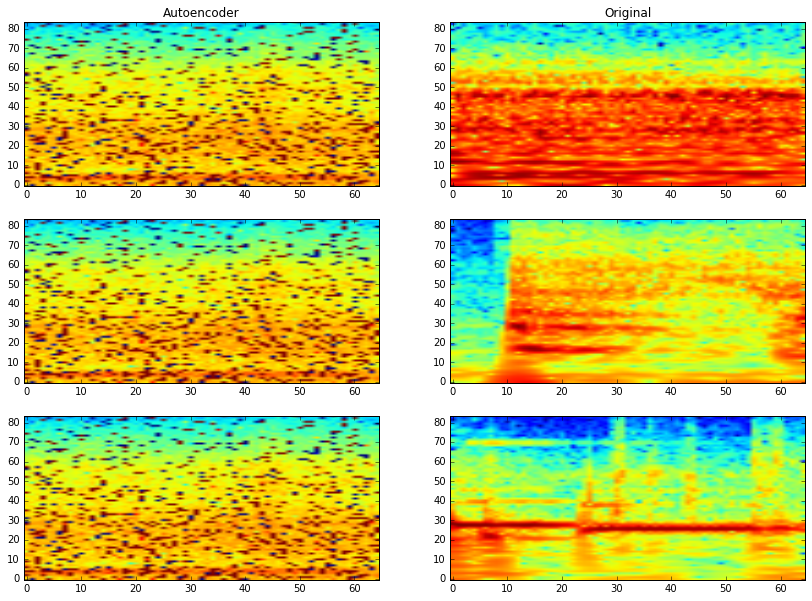

In [64]:
compare = [3,21,46]

out = sess.run(y_pred, feed_dict={X: data.data[compare]})
original = data.data[compare]
figure(figsize=(14,10))
for i,c in enumerate(compare):
    
    subplot(len(compare),2,i*2+1)
    imshow(out[i].reshape((freq_bins,time_bins)),aspect='auto',origin='bottom')
    subplot(len(compare),2,i*2+2)
    imshow(original[i].reshape((freq_bins,time_bins)),aspect='auto',origin='bottom')

subplot(len(compare),2,1)
title("Autoencoder")
subplot(len(compare),2,2)
title("Original")

# savefig("results_dim_"+str(dimensions)+"_cost_"+"{:.4f}.png".format(cost_value))

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


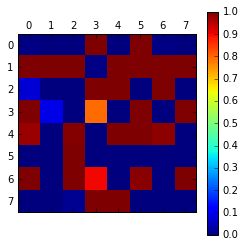

In [65]:
out = sess.run(encoder_op, feed_dict={X: data.data[3:4]})
matshow(out.reshape((8,dimensions[-1]/8)))
colorbar()

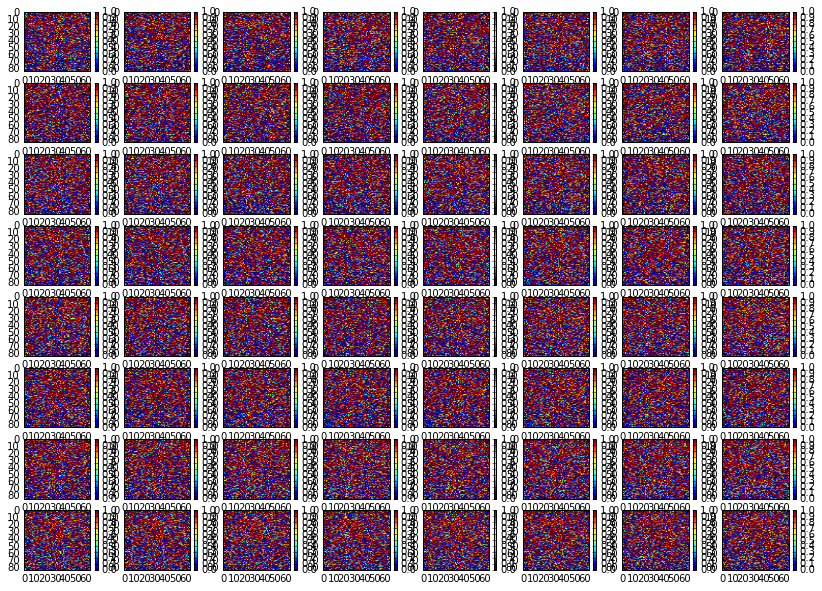

In [66]:
Y = np.zeros((1,dimensions[-1]),dtype=np.float32)
figure(figsize=(14,10))
for i in range(dimensions[-1]):
    Y[0,i] = 1
    out = sess.run(decoder(Y), feed_dict={X: data.data[3:4]})
    subplot(dimensions[-1]/8,8,i+1)
    imshow(out.reshape((freq_bins,time_bins)),aspect='auto')
    colorbar()

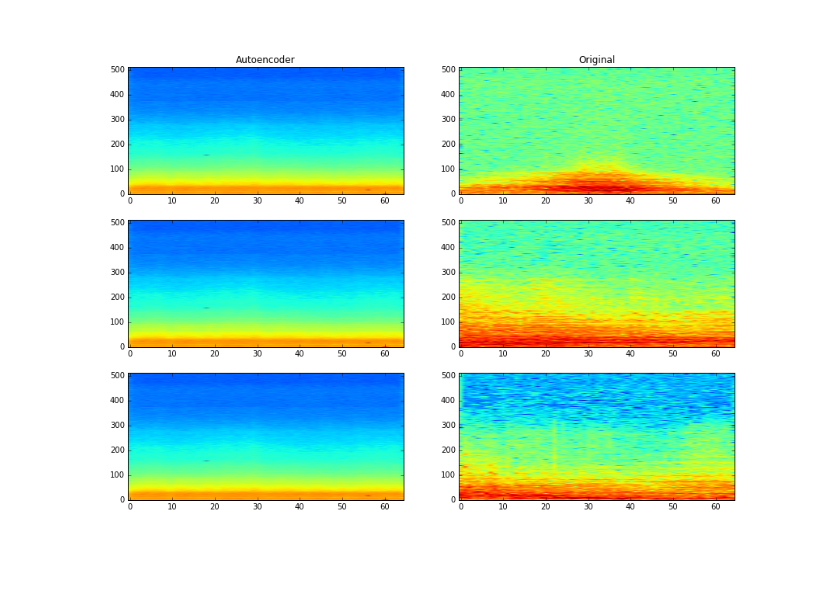

In [21]:
I = imread("results_dim_[256, 64]_cost_0.0082.png")
figure(figsize=(14,10))
imshow(I)
plt.axis('off');